In [1]:
import mdtraj as md
import os, sys, importlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def source_module_attr(module_file:str, attr_name:str, local_attr_name:str = None):
    
    """to add a module from a user defined python script into the local name space"""
    

    if local_attr_name is None:
        local_attr_name = attr_name
    
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)
    
    module = importlib.import_module(module_file.split("/")[-1][:-3])
    
    g = globals()
    g[local_attr_name] = getattr(module, attr_name)
    
    pass

def source_module(module_file: str, local_module_name: str = None):

    """to add a module from a user defined python script into the local name space"""

    #
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")

    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)

    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))

    g = globals()
    g[local_module_name] = module

    pass



#source modules and classes being developed 
source_module_attr("./writhe.py", "Writhe") #class
source_module_attr("./writhe_graph.py", "WritheGraph") #class
source_module_attr("./lightning_graph.py", "GraphDataSet") #class
source_module("./visualize.py") #module
source_module("./utils.py") #module
source_module_attr("/home/t/Downloads/msmtool.py", "calc_SA","SA")

 # Load MDTraj Trajectory Object

In [2]:
# dcd = "./asyn/asyn_Cterm_apo.all.dcd"
# pdb = "./asyn/asyn.cterm.mae2pdb.pdb"
# protein_name = "Apo Asyn C-Term"
# out_dir = "./asyn/cterm/apo"
# sele = "protein and not resid 20"

# dcd = "./asyn/asyn_full_lig47_trunc.protein.dcd"
# pdb = "./asyn/asyn_full_lig47_trunc.protein.pdb"
# protein_name = "Full Asyn + lig47"
# out_dir = "./asyn/full/lig47"


# dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
# pdb = "/home/t/writhe/actr/ACTR.pdb"
# protein_name = "ACTR"
# out_dir = "./ACTR"
# sele = "protein and (resid 0 to 70)"

dcd = "./ntail.apo.300K.dcd"
pdb = "./Ntail.apo.pdb"
sele = "protein and (resid<21)"
out_dir = "./ntail/apo"
protein_name="N$_{TAIL}$"

# table,bonds = md.load(pdb).topology.to_dataframe()
# table.sort_values("resSeq", inplace = True, ignore_index = True)
# top = md.Topology.from_dataframe(table, bonds)

trj = md.load(dcd, top=pdb,stride=1).center_coordinates()
trj = trj.atom_slice(trj.topology.select(sele))
residues=[str(trj.topology.residue(i)) for i in range(trj.n_residues)]

 # Compute Writhe, Generate Matrices For Visualization and Store Results In Writhe Class Instance For Plotting Later

In [3]:
#get CA coords
xyz = trj.atom_slice(trj.topology.select("name CA")).xyz
#instantiate writhe class
writhe = Writhe(xyz)
#compute writhe at segment length : 2 (uses parallelization over the cpu cores)
writhe_data = writhe.compute_writhe(length = 2,
                                    matrix = True,
                                    store_results = True,
                                    return_segments=False,
                                    adj_matrix=False)

2023-08-27 23:04:53,684	INFO worker.py:1636 -- Started a local Ray instance.


 # Test Speed The Parallelized Computation

In [4]:
#test the speed of the calculation without storing and reshaping data
writhe.compute_writhe(length=2, speed_test=True)
print(f"Frame Count : {trj.n_frames}")

Time elapsed : 2.058095693588257 s
Frame Count : 119921


# Use Writhe Class Plotting Functions to visualize the results.
# The make_structures and plot_structure functions generate pymol respresentations of the structures corresponding to the writhe data on the fly.

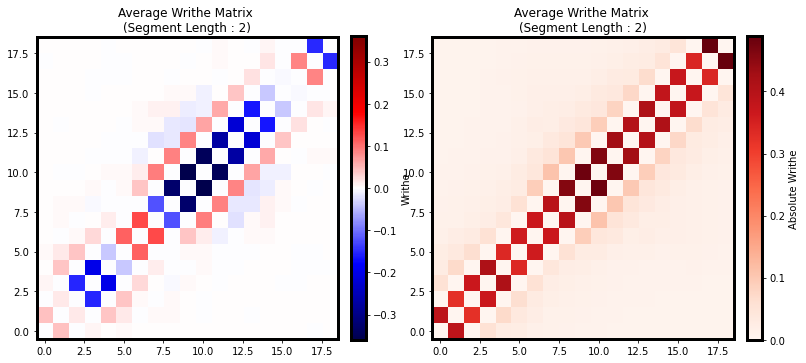

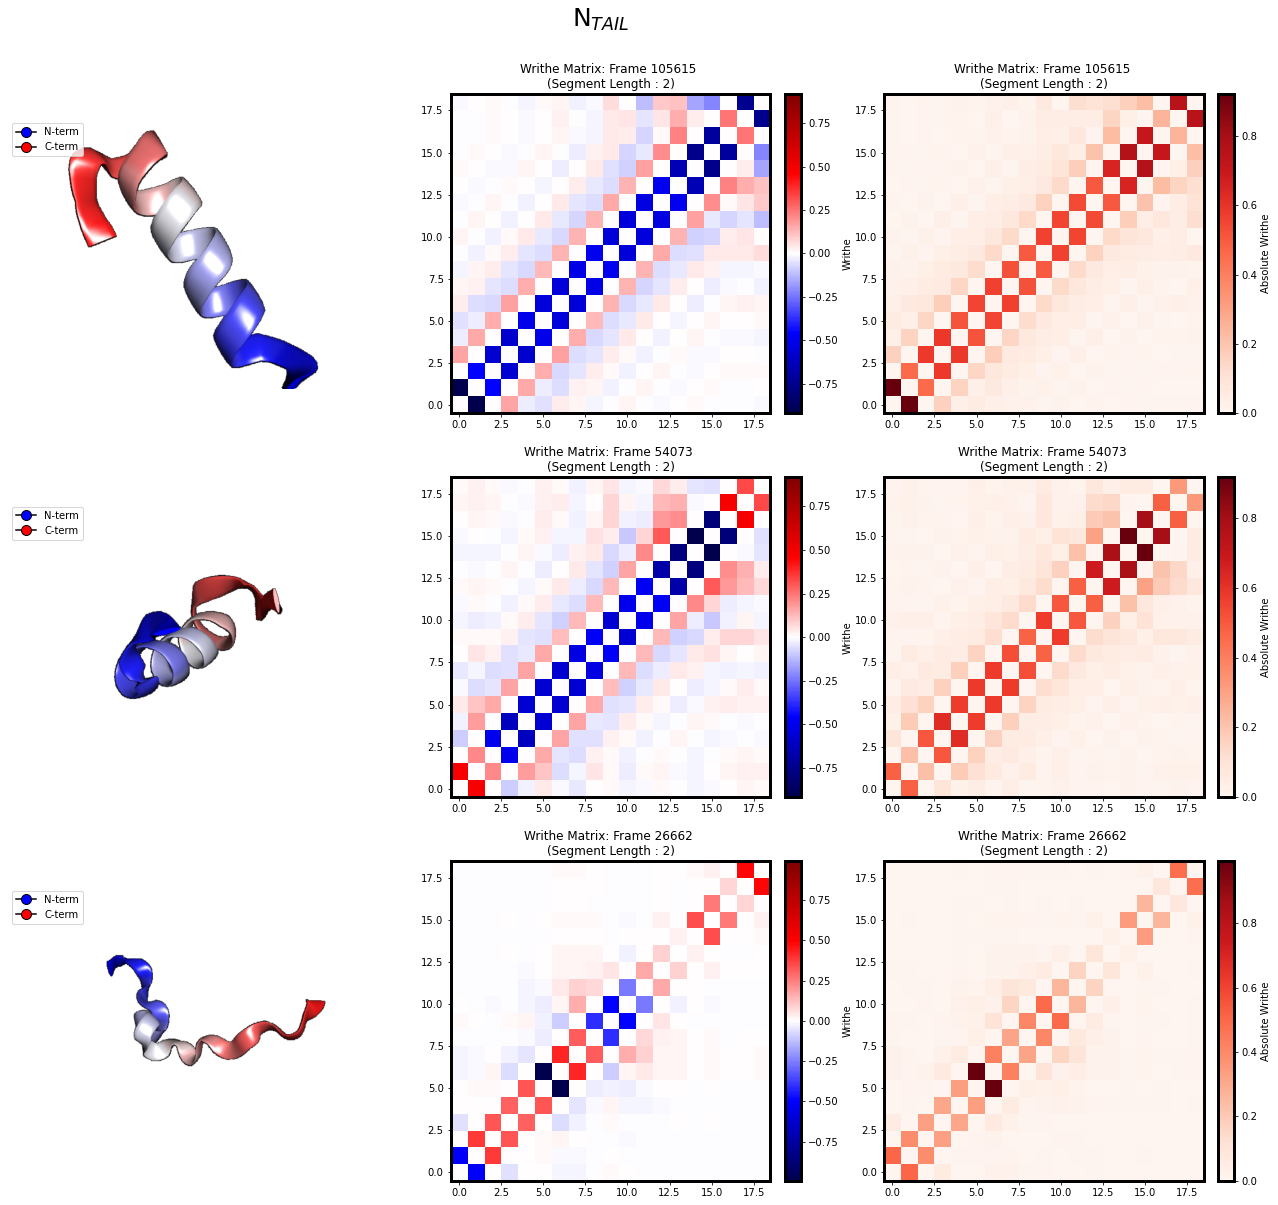

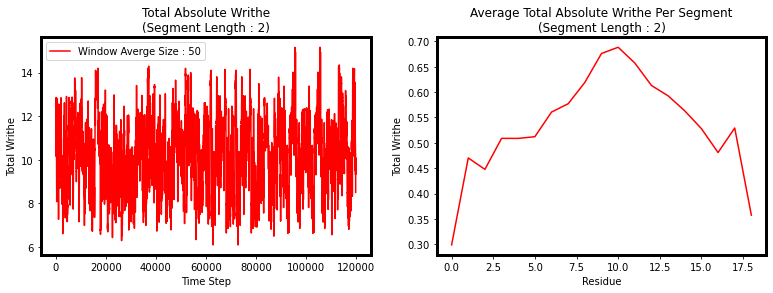

In [5]:
fig, axes = plt.subplots(1,2,figsize=(13,13))
ax=axes.flat
#plot the average 
writhe.plot_writhe_matrix(ax=ax[0])
#plot the absolute value average
writhe.plot_writhe_matrix(absolute=True,ax=ax[1])

#plot the writhe matrix at different timesteps
fig,axes=plt.subplots(3,3, figsize=(22,20))

idx=abs(writhe_data["writhe_features"]).sum(1).argsort()[::-1].astype(int)

#asyn apo c-term indices : idx[0], 168477, 34708
#indices = [idx[0], 168477, 34708]

# ACTR indices idx[[4,20]].tolist()+[idx[-15000]]
indices = idx[[4,20]].tolist()+[idx[-15000]]

fig.suptitle(protein_name, fontsize=25, y=.94)
for ax, index in zip(axes, indices):
    structure=visualize.make_structures(trj=trj, indices=index, dir=f"{out_dir}/images")
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe.plot_writhe_matrix(index=index, ax=ax[1])
    writhe.plot_writhe_matrix(index=index, ax=ax[2], absolute=True)
    
    
#plot the total absolute writhe in a time series with a windowed average
fig, axes = plt.subplots(1,2,figsize=(13,4))
ax=axes.flat
writhe.plot_writhe_total(window=50,ax=ax[0])
#plot the average absolute writhe per segment
writhe.plot_writhe_per_segment(ax=ax[1])


In [7]:
sa=SA(trj,md.load("./Ntail.helix.pdb"))

In [24]:
np.diag_indices(21, 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]))

In [ ]:
i,j = np.diag_indices()
indices=utils.flat_index()

In [ ]:
idx=np

In [14]:
indices=np.triu_indices(21-length, -2)

In [16]:
indices[0].shape

(147,)

In [ ]:
utils.triu_flat_indices()

In [ ]:
plt.plot()

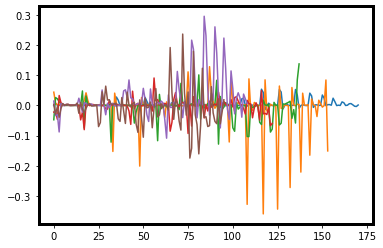

In [13]:
for i in writhe_datasets:
    plt.plot(i.mean(0))

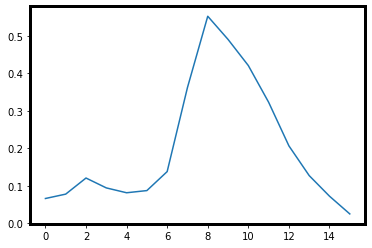

In [8]:
plt.plot(sa.mean(0))

# Use Same Instance To Compute and Plot Writhe Data At Different Segment Lengths

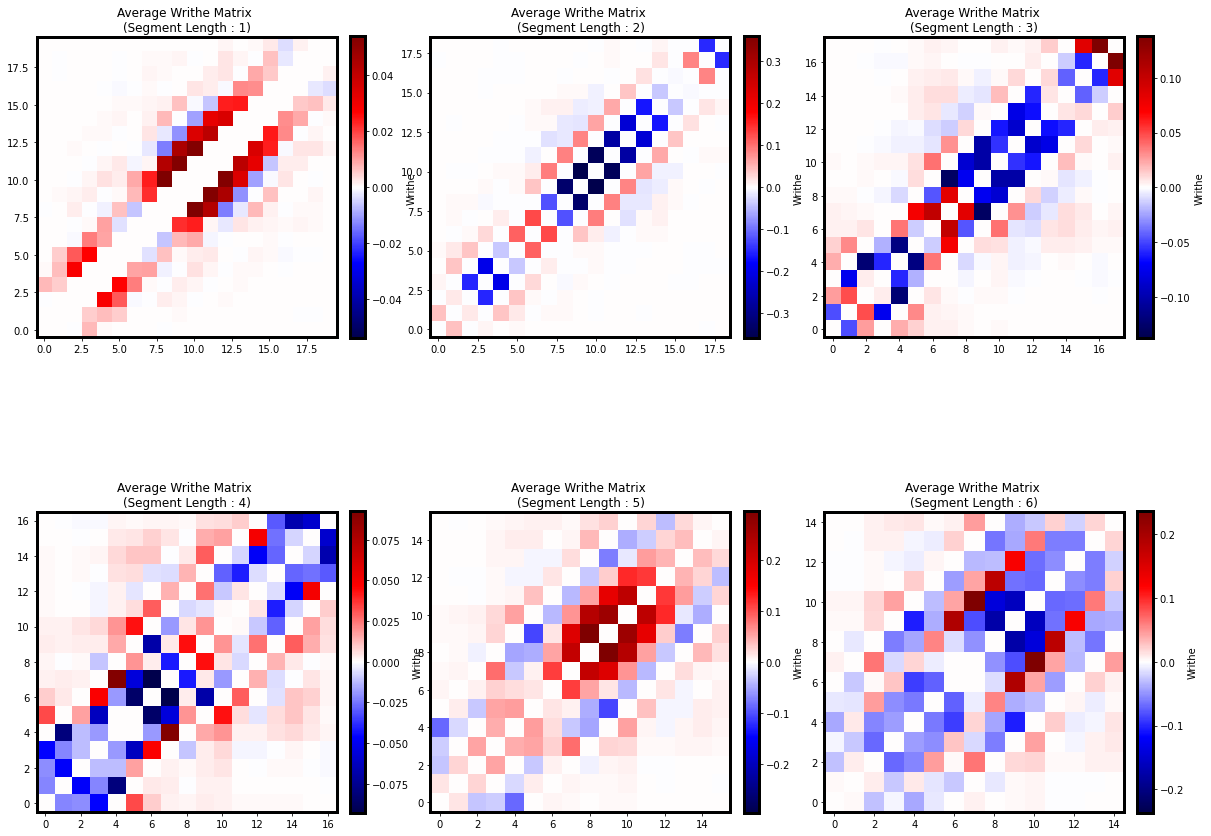

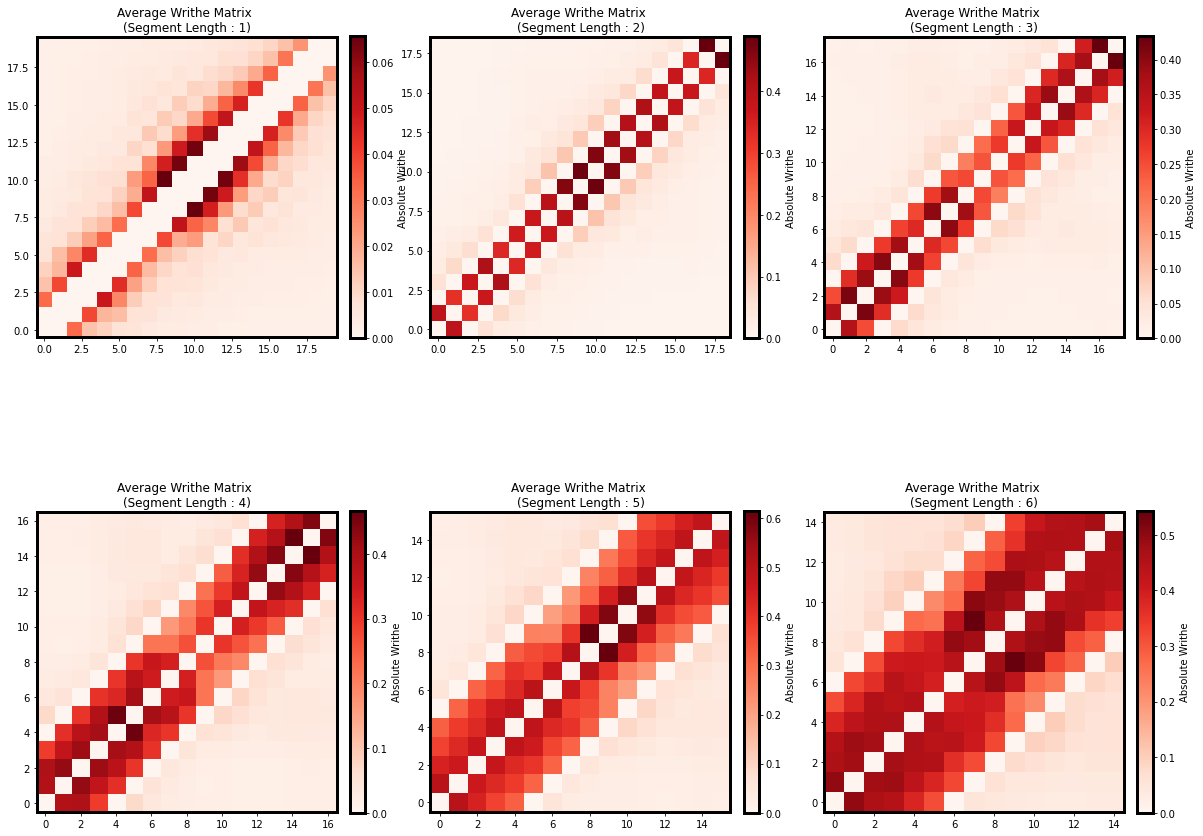

In [21]:
#compute and plot the writhe for different segment lengths
lengths=[1,2,3,4,5,6]
writhe_datasets=[]
fig, axes = plt.subplots(2,3, figsize=(20,16))
fig_abs, axes_abs = plt.subplots(2,3, figsize=(20,16))
for ax, ax_abs,length in zip(axes.flat, axes_abs.flat, lengths):
    writhe_data_ = writhe.compute_writhe(length = length,
                                         matrix = True,
                                         store_results = True,
                                        )
    writhe_datasets.append(writhe_data_["writhe_features"])
    writhe.plot_writhe_matrix(ax=ax)
    writhe.plot_writhe_matrix(ax=ax_abs,absolute=True)




# Compute the VAMP scores of writhe, intramolecular distance datasets datasets and compare 

In [20]:
from numpy.linalg import inv, eig, eigh
def halfinv(x):
    l,v=eigh(x)
    return v@np.diag(1/np.sqrt(l))@v.T
def center(x):
    return x-x.mean(0)
def cov(x,y=None):
    if y is None:
        y=x
    return center(x).T@center(y)*(1/(len(x)-1))
def svals(x):
    """compute just the **squared** singular values (or eigen values) from svd.
    If the matrix is symmetric, these will be the singular values"""
    return np.sort(eig(x.T@x)[0])[::-1]
def svd(x,dim):
    "compute the business half of econ svd"
    l,v=eig(x.T@x)
    idx=l.argsort()[::-1]
    v=v[...,idx]
    l=l[idx]
    return l[:dim],v[...,:dim]

CCA=lambda x0,xt : halfinv(cov(x0)) @ cov(x0,xt) @ halfinv(cov(xt))
tCCA=lambda x,lag : CCA(x[:-lag],x[lag:])
vamp2=lambda x,lag,dim,sum_=True : svals(tCCA(x,lag))[:dim].sum() if sum_ else svals(tCCA(x,lag))[:dim]
#for stochastic matrix, +1 for constant fxn
decompose=lambda x,lag,dim : svd(tCCA(x,lag),dim)
project=lambda x,lag,dim : center(x) @ halfinv(cov(x)) @ svd(tCCA(x,lag),dim)[-1]

In [8]:
#compute distances
distances=md.compute_contacts(trj,np.stack(np.triu_indices(len(residues),1)).T)[0]

#compute the scores at increasing lagtimes
lags=list(range(1,102,10))
eigen_values=[]
for writhe_data_ in writhe_datasets:
    
    #compute writhe with increasing segment length
    #writhe_data_=writhe.compute_writhe(length=length)["writhe_features"]
    
    #remove distances from residue pairs "length" or less apart in sequence
    distance_data=distances[:,utils.triu_flat_indices(len(residues),1,length)]
    
    
    
    #compute scores over a range of lagtimes
    eigen_values.append(np.asarray([[vamp2(data,lag,5,False) for data in [distance_data,writhe_data_]]
                            for lag in lags]))
    
eigen_values=np.stack(eigen_values)
scores=eigen_values.sum(-1)

NameError: name 'scores' is not defined

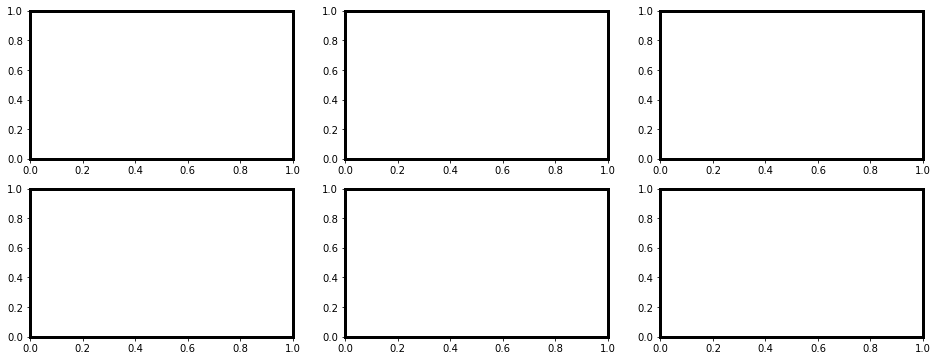

In [19]:
from matplotlib.lines import Line2D
fig,axes=plt.subplots(2,3,figsize=(16,6),)
for ax,length,score in zip(axes.flat,lengths,scores):
    
    ax.plot(lags,score[...,1],
             label=f"Writhe (Segment Length : {length})",
             color="indianred",
             lw=2,
             ls="--")
    ax.scatter(lags,score[...,1], color="black")
    
    ax.scatter(lags,score[...,0], color="black")
    
    ax.plot(lags,score[...,0],
             label=f"Intra Residue Distances, $j$ - $i$ $\geq$ {length}",
             color="gray",
             lw=2,
             ls="--")
    

    ax.set_ylabel("$VAMP_{2}$ Score (dim : 5)")
    ax.set_xlabel(r"Lag Time, $\tau$")
    ax.set_title(f"Segment Length : {length}")
    
fig.suptitle(protein_name, fontsize=25, y=.96)
plt.tight_layout()

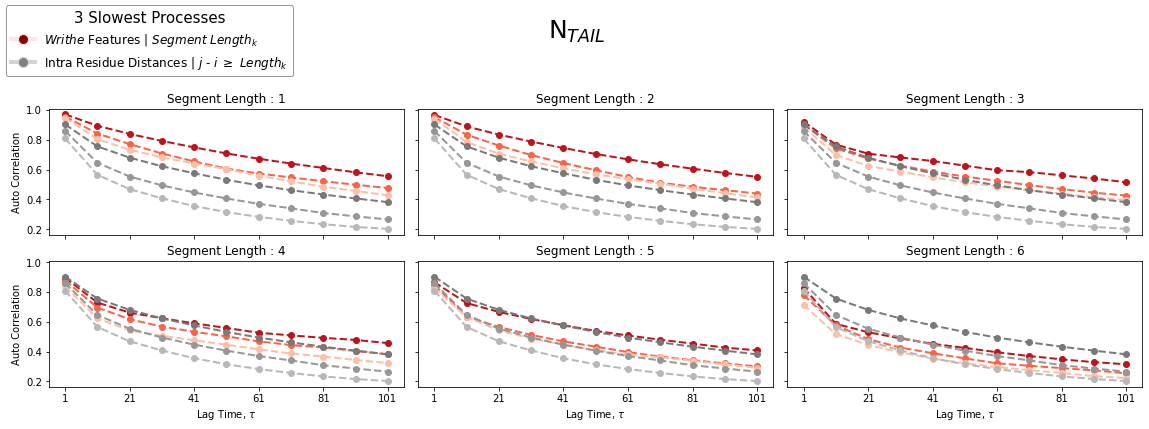

In [11]:
from cycler import cycler
n_procs=3
fig,axes=plt.subplots(2,3,figsize=(16,6),sharey=True, sharex=True)
for ax,length,eigen_value in zip(axes.flat,lengths,eigen_values):
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Reds_r",trunc=60,pre_trunc=50)
                             )))
    
    ax.plot(np.stack([eigen_value[:,1,i] for i in list(range(n_procs))]).T,
             label=f"Writhe (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    
    ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_procs,"Greys_r",trunc=100, pre_trunc=100)
                             )))
    
    ax.plot(np.stack([eigen_value[:,0,i] for i in list(range(n_procs))]).T,
             label=f"Writhe Features (Segment Length : {length})",
             lw=2,
             ls="--",
             marker="o")
    ax.set_xticks(range(0,len(lags),2),lags[::2])

    
    ax.set_title(f"Segment Length : {length}")


for ax in axes[:,0]:
    ax.set_ylabel("Auto Correlation")
for ax in axes[-1]:
    ax.set_xlabel(r"Lag Time, $\tau$")
    
    
    #ax.legend()

fig.suptitle(protein_name, fontsize=25, y=.96)
legend_elements = [Line2D([0], [0], marker="o", color='mistyrose',
                          label="$Writhe$ Features | $Segment$ $Length_{k}$",
                          markerfacecolor="darkred", markersize=10, lw=4),
                   Line2D([0], [0], marker="o", color='lightgray',
                          label='Intra Residue Distances | $j$ - $i$ $\geq$ $Length_{k}$',
                          markerfacecolor="gray", markersize=10,lw=4)]
fig.legend(handles=legend_elements,title=f"{n_procs} Slowest Processes",loc="upper left",
          fontsize=12, title_fontsize=15, edgecolor=(.5,.5,.5))
plt.tight_layout()
plt.subplots_adjust(top=.75)

 # What Segment length(s) should be used?
 
 
 
 
 
    We can plot the VAMP score as a function of the writhe segment length to determine the optimal
    segment length(s) for identifying slow dynamical modes/conformational transitions from our trajectory data.
 


Text(0.5, 1.0, 'N$_{TAIL}$')

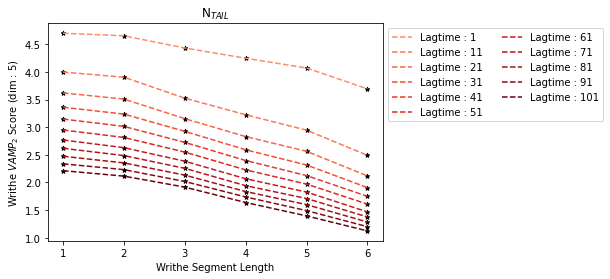

In [42]:
plt.figure()
for score,label,color in zip(scores[...,1].T,
                             [f"Lagtime : {lag}" for lag in range(1,102,10)],
                             visualize.get_color_list(len(lags),"Reds_r",trunc=100)[::-1]):
    
    plt.plot(lengths,score,color=color,label=label,ls="--")
    plt.scatter(lengths,score,color="black",s=20,marker="*")
    
plt.xticks(range(1,lengths[-1]+1))
plt.ylabel("Writhe $VAMP_{2}$ Score (dim : 5)")
plt.xlabel(r"Writhe Segment Length")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left',ncol=2)
plt.title(protein_name)


# From the vamp score, we see that writhe datasets computed with segment lengths of 1 and 2 are best.

    When combining writhe datasets computed using different segment lengths as a means for finding an optimal
    input for dimensionality reduction or deep learning models, the relaxation timescales (vamp score computed at varying lagtimes) should be similar at the lagtime of the model. This is because these models generally aim to maximize the autocorrelation of the transformed data at a target lagtime.

    Given that writhe computed at different length scales probe different geometric features of a protein's
    topology, combining these datasets should provide a rich description of the system and it's dynamics (under the restraint that their relaxation times are similar).

# Here, we'll combine the writhe data sets computed at segment lengths 1 and 2.




In [12]:
# make a writhe feature set using segment lengths 1 and 2
# writhe_feature_set = np.concatenate([writhe.compute_writhe(l)["writhe_features"] for l in [1,3]],
#                                     axis=1)
#writhe_datasets=np.stack(writhe_datasets)
writhe_feature_set=np.concatenate([writhe_datasets[i] for i in [1,2]],axis=-1)

 # Let's project the writhe and distance data onto the dominant singular functions of their Koopman matrices

In [18]:
lam,v = decompose(writhe_feature_set, 5, 2)

NameError: name 'decompose' is not defined

In [17]:
plt.plot(v[...,1])

NameError: name 'v' is not defined

In [13]:
lag=5
writhe_projection = project(writhe_feature_set, lag, 2)
distance_projection = project(distances[:,utils.triu_flat_indices(len(residues),1,2)], lag, 2)

Text(0.48, 1, 'N$_{TAIL}$')

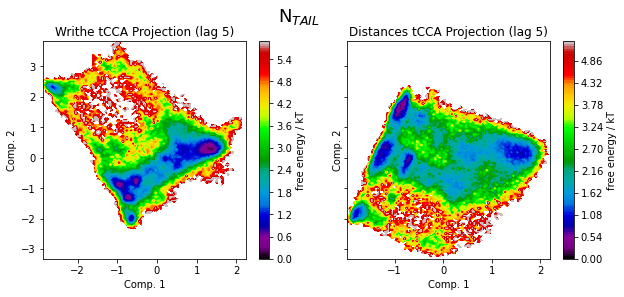

In [14]:
import pyemma
fig,axes=plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax,name,data in zip(axes.flat, 
                        "Writhe,Distances".split(","),
                        [writhe_projection,distance_projection]):
    ax.set_xlabel("Comp. 1")
    ax.set_ylabel("Comp. 2")
    ax.set_title(f"{name} tCCA Projection (lag {lag})")
    pyemma.plots.plot_free_energy(*data.T,ax=ax )
fig.suptitle(protein_name, fontsize=18, y=1,x=.48)

 # Let's try a geometrically perfect helix

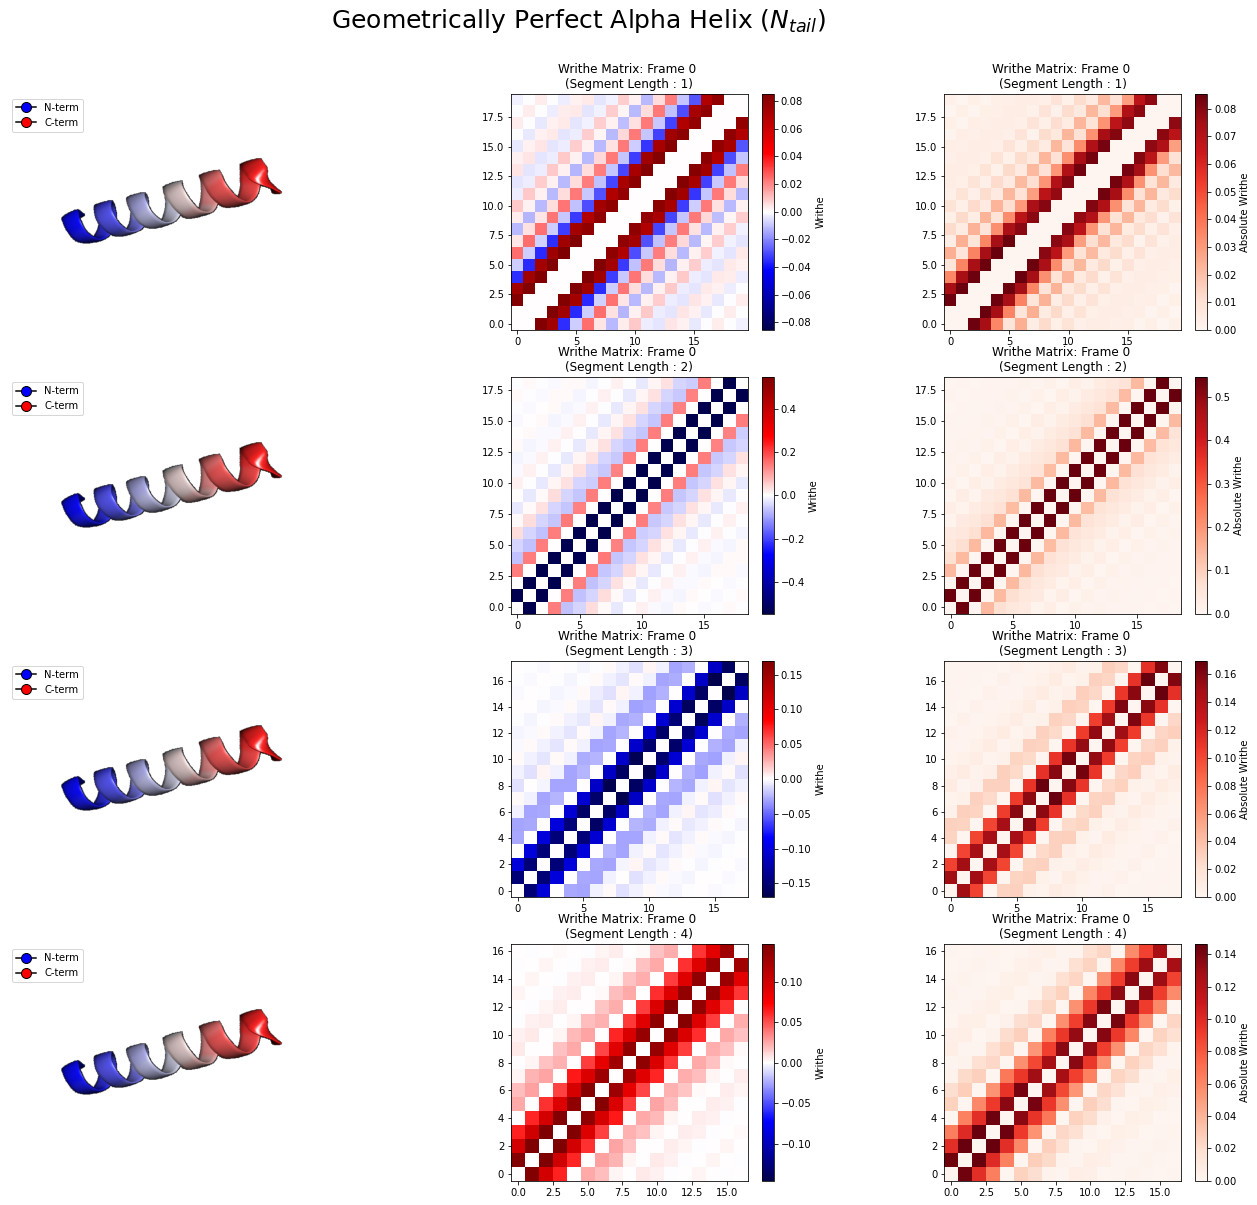

In [17]:
helix = md.load("./Ntail.helix.pdb")
#get CA coords
xyz_helix = helix.atom_slice(helix.topology.select("name CA")).xyz
#instantiate writhe class
writhe_helix = Writhe(xyz_helix)
#compute writhe at segment length : 4 (uses parallelization over the cpu cores)

fig,axes=plt.subplots(4,3, figsize=(22,20))
structure=visualize.make_structures(trj=helix, indices=0, dir="./ntail_helix/images")

fig.suptitle('Geometrically Perfect Alpha Helix ($N_{tail}$)', fontsize=25, y=.94)
for ax, segment_length in zip(axes, [1,2,3,4]):
    writhe_data = writhe_helix.compute_writhe(length = segment_length,
                                matrix = True,
                                store_results = True,
                                return_segments=False,
                                adj_matrix=False)
    visualize.plot_structure(image=structure, ax=ax[0])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[1])
    writhe_helix.plot_writhe_matrix(index=0, ax=ax[2], absolute=True)

 # Make Graph Representations For All Frames of The Trajectory

In [7]:
#make instance of writhe graph
graph = WritheGraph(trj)

#add edge features
graph.add_dihedrals() #0,1
graph.add_angles() #2,3
graph.add_intra_distances() #4
graph.add_writhe(segment_length = 1) #5
graph.add_writhe(segment_length = 3) #6
graph.add_writhe(segment_length = 5) #7

#add node_features
#graph.add_ligand_distances() #0
graph.add_dssp() #1
graph.add_rsa() #2

#set up
graph.make_edge_dict()

In [8]:
#make a graph for each frame
graphs = [graph.get_graph(i) for i in range(graph.nf)]

#set a directory to save to
root="./actr/graphs"
os.mkdir(root)

# GraphDataSet class collates all graph examples into one giant graph
# and stores them for efficient access during training

graph_dataset = GraphDataSet(root=root, name="graph", data_list=graphs)

Processing...
Done!
